In [1]:
import h5py
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import cv2
import imageio
import io
import glob
import pandas as pd
import pickle
import sys
import random

def load_video_frames(h5_file, camera_id = '18650758_left', resize_hw = None, convert_to_rgb = True, image_aug = False):
    """Extract frames (as numpy RGB images) from the mp4 bytes stored in the HDF5 file.

    Args:
        h5_file: opened h5py.File
        camera_id: key inside observation/videos mapping to mp4 bytes
        resize_hw: optional (height, width) to resize frames using cv2

    Returns:
        frames: np.ndarray of shape (T, H, W, 3) dtype uint8 (RGB)
    """
    if "observation" not in h5_file or "videos" not in h5_file["observation"]:
        raise KeyError("Could not find observation/videos group in this file.")

    videos_grp = h5_file["observation"]["videos"]
    if camera_id not in videos_grp:
        raise KeyError(f"Camera id {camera_id} not found in observation/videos group.")

    video_dataset = videos_grp[camera_id]
    video_bytes = video_dataset[()]
    if hasattr(video_bytes, 'tobytes'):
        video_bytes = video_bytes.tobytes()

    buf = io.BytesIO(video_bytes)
    reader = imageio.get_reader(buf, format="mp4")
    frames = []
    try:
        for frame in reader:
            if convert_to_rgb:
            # Convert BGR to RGB
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if resize_hw is not None:
                frame = cv2.resize(frame, (resize_hw[1], resize_hw[0]))
            if image_aug:
                h, w = frame.shape[:2]
                # Random crop (95% of original size)
                crop_h = int(h * 0.95)
                crop_w = int(w * 0.95)
                top = random.randint(0, h - crop_h)
                left = random.randint(0, w - crop_w)
                frame = frame[top:top+crop_h, left:left+crop_w]
                
                # Resize back to original dimensions
                frame = cv2.resize(frame, (w, h), interpolation=cv2.INTER_LINEAR)
                
                # Random rotation (-5 to 5 degrees) with reflective border
                angle = random.uniform(-5, 5)
                center = (w // 2, h // 2)
                rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
                frame = cv2.warpAffine(
                    frame,
                    rotation_matrix,
                    (w, h),
                    flags=cv2.INTER_LINEAR,
                    borderMode=cv2.BORDER_REFLECT_101,
                )
                
                # Color jitter: brightness, contrast (around mean), saturation in random order
                frame = frame.astype(np.float32)
                b_factor = random.uniform(0.7, 1.3)  # ±0.3
                c_factor = random.uniform(0.6, 1.4)  # ±0.4
                s_factor = random.uniform(0.5, 1.5)  # ±0.5

                def _apply_brightness(img: np.ndarray) -> np.ndarray:
                    return img * b_factor

                def _apply_contrast(img: np.ndarray) -> np.ndarray:
                    mean = img.mean(axis=(0, 1), keepdims=True)
                    return (img - mean) * c_factor + mean

                def _apply_saturation(img: np.ndarray) -> np.ndarray:
                    img_uint8 = np.clip(img, 0, 255).astype(np.uint8)
                    hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)
                    hsv = hsv.astype(np.float32)
                    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * s_factor, 0, 255)
                    hsv = np.clip(hsv, 0, 255).astype(np.uint8)
                    out = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
                    return out.astype(np.float32)

                ops = [_apply_brightness, _apply_contrast, _apply_saturation]
                random.shuffle(ops)
                for op in ops:
                    frame = op(frame)
                
                # Ensure values are in valid range
                frame = np.clip(frame, 0, 255).astype(np.uint8)
            frames.append(frame)
    finally:
        reader.close()

    return np.stack(frames, axis=0)


def view_video_frames(video_frames, start_frame, end_frame=None):
    if end_frame is None:
        # Show only the start frame
        plt.figure(figsize=(8, 6))
        plt.imshow(video_frames[start_frame])
        plt.axis('off')
        plt.show()
    else:
        # Show all frames from start to end frame inclusive
        num_frames = end_frame - start_frame + 1
        cols = min(4, num_frames)
        rows = (num_frames + cols - 1) // cols
        
        plt.figure(figsize=(4 * cols, 4 * rows))
        for i, frame_idx in enumerate(range(start_frame, end_frame + 1)):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(video_frames[frame_idx])
            plt.title(f'Frame {frame_idx}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

def create_video_with_primitives(video_frames, h5_file, output_path='/iris/u/jrpan/robo_memory/output_video.mp4', fps=15):
    """
    Create a video with action primitive text overlays on each frame.
    
    Args:
        video_frames: List of video frames
        h5_file: Open h5py file containing action primitive data
        output_path: Path to save the output video
        fps: Frames per second for the output video
    """
    writer = imageio.get_writer(output_path, fps=fps, format='mp4')

    try:
        for i, frame in enumerate(video_frames):
            action_primitive = h5_file['observation']['action_primitive_pressed'][i].decode('utf-8')

            frame_with_text = frame.copy()
            text = f"Frame {i}: {action_primitive}"
            
            # Get frame dimensions to ensure text stays within boundaries
            height, width = frame_with_text.shape[:2]
            
            # Calculate text size to ensure it fits
            font_scale = 0.3
            font_thickness = 1
            (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
            
            # Position text with padding from edges, ensuring it stays within frame
            x_pos = max(5, min(10, width - text_width - 5))
            y_pos = max(text_height + 5, 20)
            y_pos = min(y_pos, height - 5)
            
            cv2.putText(frame_with_text, 
                        text,
                        (x_pos, y_pos), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        font_scale,  
                        (255, 255, 255), 
                        font_thickness) 
            frame_bgr = frame_with_text[..., ::-1] 
            writer.append_data(frame_bgr)
    finally:
        writer.close()

    print(f"Video saved to {output_path}")

[ 29  58  98 237 355 476  -1]
(583, 180, 320, 3)


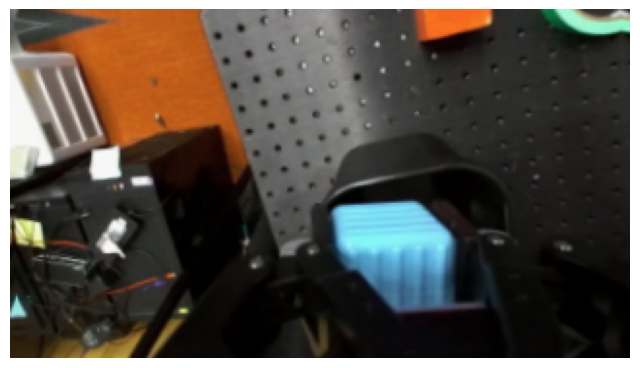

In [5]:
data_path = "/iris/u/ajaysri/datasets/keyframe_data/bin_memory_keyframe_h5/train/2025-07-04__Fri_Jul__4_01_27_06_2025_keyframes.h5"
f = h5py.File(data_path, 'r')
# print("observation/wrist_image_left:", f['observation']['videos']['25916956_left'])
# print("observation/exterior_image_1_left:", f['observation']['videos']['18650758_left'])
# print("observation/joint_position:", f['observation']['robot_state']['joint_positions'])
# print("observation/gripper_position:", f['observation']['robot_state']['gripper_position'])
# print("prompt:", f['observation']['action_primitive_pressed'])

# print("actions: joint velocity:", f['action']['joint_velocity']) 
# print("actons: gripper position:", f['action']['gripper_position'])
# print(f['observation']['action_primitive_pressed'][()])

print(f['metadata']['keyframe_indices'][()])
video_frames = load_video_frames(f, '18650758_left', resize_hw=(180, 320), image_aug=True)
print(video_frames.shape)
view_video_frames(video_frames, 200)
# create_video_with_primitives(video_frames, f)


### Processing DROID data into LeRobot

In [ ]:
# GET THRESHOLD FOR NEAR-ZERO RESETTING ACTIONS

SPLIT = "train"
THRESHOLD = 0.1
data_path = f"/iris/u/ajaysri/datasets/bin_memory_cleaned_data/{SPLIT}/*.h5"
h5_files = glob.glob(data_path)

def find_bottom_percent_joint_velocity_norm(h5_files, threshold=THRESHOLD):
    print(f"Processing {len(h5_files)} files")
    
    all_norms = []
    all_vectors = []
    all_info = []  # Store file path, index, and prompt for reference

    # collect all joint velocity norms and vectors
    for file_path in h5_files:
        with h5py.File(file_path, 'r') as h5_file:
            prompt = h5_file['observation']['action_primitive_pressed'][:]
            joint_velocity = h5_file['action']['joint_velocity'][:]

            for i in range(len(prompt)):
                primitive_str = prompt[i].decode('utf-8') if isinstance(prompt[i], bytes) else str(prompt[i])
                if primitive_str == "None":
                    continue

                norm_value = np.linalg.norm(joint_velocity[i])
                all_norms.append(norm_value)
                all_info.append((file_path, i, primitive_str))

    all_norms = np.array(all_norms)
    threshold_value = np.percentile(all_norms, threshold)

    # find vectors below threshold
    print(f"Finding pick-and-place vectors below {threshold_value:.6f}")
    bottom_indices = np.where(all_norms <= threshold_value)[0]
    bottom_pick_place_vectors = []
    for i, idx in enumerate(bottom_indices[:]):  
        file_path, frame_idx, primitive_str = all_info[idx]
        if "pick" in primitive_str:
            print(f"norm={all_norms[idx]:.6f}, action=\"{primitive_str}\"")
    
    return threshold_value
    
    
threshold_value = find_bottom_percent_joint_velocity_norm(h5_files)
print(f"Threshold {THRESHOLD}th percentile value: {threshold_value:.6f}")

Processing 50 files
Finding pick-and-place vectors below 0.020587
norm=0.015328, action="pick up the purple marker and put it in the black bin"
norm=0.016592, action="pick up the green tape and put it in the black bin"
norm=0.017535, action="pick up the blue block and put it in the white bin"
norm=0.015074, action="pick up the eraser and put it in the black bin"
norm=0.013309, action="pick up the fried chicken and put it in the white bin"
norm=0.017690, action="pick up the red block and put it in the white bin"
norm=0.018331, action="pick up the green tape and put it in the white bin"
norm=0.020482, action="pick up the eraser and put it in the white bin"
norm=0.019893, action="pick up the red block and put it in the black bin"
Threshold 0.1th percentile value: 0.020587


In [ ]:
SPLIT = "train"
data_path = f"/iris/u/ajaysri/datasets/bin_memory_cleaned_data/{SPLIT}/*.h5"
h5_files = glob.glob(data_path)

def create_action_primitive_dataframe(h5_files, threshold_value = threshold_value, split = SPLIT):
    """
    Create a pandas DataFrame where each row contains:
    prompt, joint_position, gripper_position, wrist_image, exterior_image, joint_velocity
    
    Args:
        h5_files: list of h5 file paths
    
    Returns:
        pd.DataFrame: DataFrame with columns for each data type
    """
    data_rows = []
    print(f"Processing {len(h5_files)} files")

    for file_path in h5_files:
        with h5py.File(file_path, 'r') as h5_file:
            joint_positions = h5_file['observation']['robot_state']['joint_positions'][:]
            action_gripper_position = h5_file['action']['gripper_position'][:]
            obs_gripper_position = h5_file['observation']['robot_state']['gripper_position'][:]
            wrist_image = load_video_frames(h5_file, '25916956_left', resize_hw=(180, 320))
            exterior_image = load_video_frames(h5_file, '18650758_left', resize_hw=(180, 320))
            # print(wrist_image.shape)
            prompt = h5_file['observation']['action_primitive_pressed'][:]
            joint_velocity = h5_file['action']['joint_velocity'][:]

            assert len(joint_velocity) == len(prompt) == len(joint_positions) == len(obs_gripper_position), f"Lengths not equal: {len(joint_velocity)} != {len(prompt)} != {len(joint_positions)} != {len(action_gripper_position)}"
            
            for i in range(len(prompt)):
                primitive_str = prompt[i].decode('utf-8') if isinstance(prompt[i], bytes) else str(prompt[i])
                if primitive_str == "None":
                    continue
                
                if split == "train" and np.linalg.norm(joint_velocity[i]) < threshold_value and "look" in primitive_str: # don't train on resetting actions during bin looking (norm falls under threshold_value)
                    continue
                
                data_rows.append({
                    "prompt": primitive_str,
                    "joint_position": joint_positions[i],
                    "gripper_position": np.array([obs_gripper_position[i]]),
                    "wrist_image": wrist_image[i],
                    "exterior_image": exterior_image[i],
                    "joint_velocity": joint_velocity[i],
                    "action_gripper_position": np.array([action_gripper_position[i]]),
                })
    
    return pd.DataFrame(data_rows)

action_primitive_df = create_action_primitive_dataframe(h5_files)
action_primitive_df['actions'] = action_primitive_df.apply(lambda x: np.concatenate([x['joint_velocity'], x['action_gripper_position']]), axis=1)
print(f"Created DataFrame with {len(action_primitive_df)} rows")
print(f"DataFrame columns: {action_primitive_df.columns.tolist()}")

Processing 50 files
Global minimum joint velocity norm: 0.000000
Found in file: /iris/u/ajaysri/datasets/bin_memory_cleaned_data/train/2025-07-03__Thu_Jul__3_21_07_16_2025.h5
At index: 81
Joint velocity vector with minimum norm: [0. 0. 0. 0. 0. 0. 0.]
Created DataFrame with 20694 rows
DataFrame columns: ['prompt', 'joint_position', 'gripper_position', 'wrist_image', 'exterior_image', 'joint_velocity', 'action_gripper_position', 'actions']


In [26]:
action_primitive_df.head()

,prompt,joint_position,gripper_position,wrist_image,exterior_image,joint_velocity,action_gripper_position,actions
0,look inside the white bin,"[-0.0004892370197921991, -0.611771821975708, -...",[0.0],"[[[157, 159, 152], [173, 175, 168], [191, 193,...","[[[56, 56, 54], [56, 56, 54], [59, 59, 57], [5...","[-0.006863746675662696, 0.0022026454098522663,...",[0.0],"[-0.006863746675662696, 0.0022026454098522663,..."
1,look inside the white bin,"[-0.00048564403550699353, -0.6117698550224304,...",[0.0],"[[[157, 159, 152], [173, 175, 168], [191, 193,...","[[[56, 56, 54], [56, 56, 54], [59, 59, 57], [5...","[-0.0013662390119861811, 0.06781233008950949, ...",[0.0],"[-0.0013662390119861811, 0.06781233008950949, ..."
2,look inside the white bin,"[-0.000485475902678445, -0.6117419600486755, -...",[0.0],"[[[157, 159, 152], [173, 175, 168], [191, 193,...","[[[56, 56, 54], [56, 56, 54], [59, 59, 57], [5...","[0.006579040200449526, 0.08653686381876469, 0....",[0.0],"[0.006579040200449526, 0.08653686381876469, 0...."
3,look inside the white bin,"[-0.00048013831838034093, -0.6113619208335876,...",[0.0],"[[[157, 159, 152], [173, 175, 168], [191, 193,...","[[[57, 57, 55], [59, 59, 57], [64, 64, 62], [6...","[0.02778858644887805, 0.13434871099889278, 0.0...",[0.0],"[0.02778858644887805, 0.13434871099889278, 0.0..."
4,look inside the white bin,"[-0.0004031120042782277, -0.6103083491325378, ...",[0.0],"[[[157, 159, 152], [173, 175, 168], [191, 193,...","[[[56, 56, 54], [59, 59, 57], [62, 62, 60], [6...","[0.04289225675165653, 0.17393792048096657, 0.1...",[0.0],"[0.04289225675165653, 0.17393792048096657, 0.1..."


In [52]:
action_primitive_df[['prompt', 'joint_position', 'gripper_position', 'wrist_image', 'exterior_image', 'actions']].to_pickle(f'action_primitive_df_{SPLIT}.pkl')